# Filter xAOD Events

This is a sample script that uses the ad-hoc analysis library to extract jet pt's from certain ATLAS xAOD events. It also demonstraits loading more than one column of data from different looping levels (run and event number). We will write out a table with:

- Run Number
- Event Number
- Jet Eta
- Jet pt

It also demonstrates using python `tuples` to organize data (see note at the end)

## Setup and Config

In [1]:
fname = r"file://G:/mc16_13TeV/AOD.16300985._000011.pool.root.1"

In [2]:
%%time
import sys
sys.path.append('..')
from clientlib.DataSets import EventDataSet

Wall time: 773 ms


## Import the events into a Pandas array.

First thing we do is turn a dataset into an implicit stream of events.

In [3]:
%%time
f = EventDataSet(fname)
events = f.AsATLASEvents()

Wall time: 0 ns


We will get the stream of jets in several steps. We could do this in one step, but it is easier to read.

Since we are reading from the atlas xAOD, we need to query the xAOD to get the `EventInfo` object and the `Jet` collection. After the below line you can think of `event_info` like a huge table, with one column the `EventInfo` object and second column the `Jet` collection, one row per event.

In [4]:
%%time
event_info = events \
            .Select("lambda e: (e.EventInfo('EventInfo'), e.Jets('AntiKt4EMTopoJets'))")

Wall time: 0 ns


The `event_info` iterator is a sequence of events - one per event. We want it to be one per jet. We use the `SelectMany` function to change the sequence into one of jets. Note that `Select` is used in the interior - this is because `e1[1]` is an array of the jets in the event - so it is already a sequence.

In [5]:
jet_info = event_info \
            .SelectMany('lambda e1: e1[1].Select(lambda j: (e1[0],j))')

Now we have a sequnce with an entry for each jet. Now we are ready to generate the tuple of data we want to writ eout. Note the conversion from MeV to GeV for the jet's pt.

In [6]:
jet_data = jet_info \
            .Select('lambda jinfo: (jinfo[0].runNumber(), jinfo[0].eventNumber(), jinfo[1].pt()/1000.0, jinfo[1].eta())')

Finally, we want to keep only jets with a `pt` of at least 40 GeV.

In [7]:
jet_filtered = jet_data \
                .Where('lambda jinfo1: jinfo1[2] > 40.0')

And finally turn it into a pandas data frame. Each row has a single jet pt.

At this point no execution happens - a "future" is now setup with the pandas dataframe.

In [8]:
%%time
training_df = jet_filtered.AsPandasDF(columns=['Run', 'Event', 'JetPt', 'JetEta'])

Wall time: 0 ns


Finally, we turn it into something real. The following steps occur:

1. Some C++ code is written to access, read the xAOD jet's, create a ttree, and write it out.
1. A docker container with the ATLAS envrionment is started. The code and the data file location are mapped into it.
1. The code is compiled, and then run.
1. The output ROOT file is loaded with uproot and a DF is created.
1. All that temporary code and data is removed.

There is a fair amount of log file information that appears in the notebook engine window. At the moement that is not correctly redirected here - so you can see evidence of it running there.

In [9]:
%%time
df = training_df.value()

Wall time: 27.6 s


## The Dataframe

Now we can play with the dataframe as we wish.

In [10]:
df

,Run,Event,JetPt,JetEta
0,300000.0,16000310.0,257.316437,1.438426
1,300000.0,16000310.0,253.132324,0.656501
2,300000.0,16000310.0,47.169453,-2.648296
3,300000.0,16000256.0,386.493408,2.073497
4,300000.0,16000256.0,339.724030,-0.082004
5,300000.0,16002559.0,205.481918,-1.160439
6,300000.0,16002559.0,145.919022,1.104241
7,300000.0,16002811.0,367.607086,1.182012
8,300000.0,16002811.0,284.545380,-0.467615
9,300000.0,16002811.0,57.873211,-1.149017


In [11]:
%%time
import matplotlib.pyplot as plt

Wall time: 253 ms


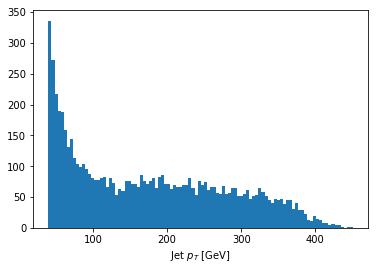

In [12]:
_ = plt.hist(df.JetPt, bins=100)
_ = plt.xlabel("Jet $p_T$ [GeV]")

Note the cut off at 40 GeV on the low end.

Wall time: 53.9 ms


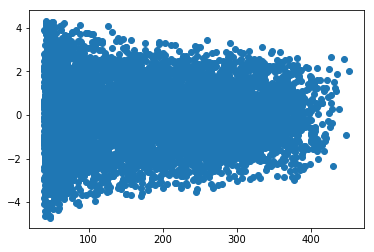

In [13]:
%%time
_ = plt.scatter(df.JetPt, df.JetEta)

As expected we can see the higher pt jets tend to be more central

## Limitations

This is demo code. There are a number of limitations:

- Only Jets, Tracks, and EventInfo is understood (easy to add new C++ collections or objects). You can alter the name of the collection you want to access.
- Basic operations are possible, like jet.pt()/1000.0. But no effor had been made to have a complete set of operations yet.
- Only a single query at a time is possible. However you can create multiple columns in the dataframe (with jet pt and eta, for example).
- Obviously, tuples quickly become unweildy. Named tuples would be the obvious thing to use - and there is no techincal reason not to use them. Eventually.

## Generated C++ code

The code generation is not ideal, so I thought it might be nice to check otu what sort of code this generates. This is the algorithm that is run in the AnalysisBase sequence, just the `.cpp` file.

```
#include <AsgTools/MessageCheck.h>
#include <analysis/query.h>

#include "xAODJet/JetContainer.h"
#include "xAODEventInfo/EventInfo.h"

#include <TTree.h>

query :: query (const std::string& name,
                                  ISvcLocator *pSvcLocator)
    : EL::AnaAlgorithm (name, pSvcLocator)
{
  // Here you put any code for the base initialization of variables,
  // e.g. initialize all pointers to 0.  This is also where you
  // declare all properties for your algorithm.  Note that things like
  // resetting statistics variables or booking histograms should
  // rather go into the initialize() function.
}

StatusCode query :: initialize ()
{
  // Here you do everything that needs to be done at the very
  // beginning on each worker node, e.g. create histograms and output
  // trees.  This method gets called before any input files are
  // connected.
  {
    ANA_CHECK (book (TTree ("analysis", "My analysis ntuple")));
    auto myTree = tree ("analysis");
    myTree->Branch("Run", &_Run2);
    myTree->Branch("Event", &_Event3);
    myTree->Branch("JetPt", &_JetPt4);
    myTree->Branch("JetEta", &_JetEta5);
  }

  return StatusCode::SUCCESS;
}

StatusCode query :: execute ()
{
  // Here you do everything that needs to be done on every single
  // events, e.g. read input variables, apply cuts, and fill
  // histograms and trees.  This is where most of your actual analysis
  // code will go.
  {
    const xAOD::JetContainer* jets0;
    {
      const xAOD::JetContainer* result = 0;
      ANA_CHECK (evtStore()->retrieve(result, "AntiKt4EMTopoJets"));
      jets0 = result;
    }

    for (auto i_obj6 : *jets0)
    {
      if (((i_obj6->pt()/1000.0)>40.0))
      {
        const xAOD::EventInfo* eventinfo1;
        {
          const xAOD::EventInfo* result = 0;
          ANA_CHECK (evtStore()->retrieve(result, "EventInfo"));
          eventinfo1 = result;
        }
        _Run2 = eventinfo1->runNumber();
        _Event3 = eventinfo1->eventNumber();
        _JetPt4 = (i_obj6->pt()/1000.0);
        _JetEta5 = i_obj6->eta();
        tree("analysis")->Fill();
      }
    }
  }

  return StatusCode::SUCCESS;
}

StatusCode query :: finalize ()
{
  // This method is the mirror image of initialize(), meaning it gets
  // called after the last event has been processed on the worker node
  // and allows you to finish up any objects you created in
  // initialize() before they are written to disk.  This is actually
  // fairly rare, since this happens separately for each worker node.
  // Most of the time you want to do your post-processing on the
  // submission node after all your histogram outputs have been
  // merged.
  return StatusCode::SUCCESS;
}
```